<a href="https://colab.research.google.com/github/claubermartins/Stock-market-prediction/blob/main/stock_market_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install inflection

**1-Importando bibliotecas**

In [ ]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, LSTM 
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import datetime
import inflection
from IPython.core.display import HTML

**3-Funções auxiliares**

In [ ]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [ ]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


**3-Importando a base de dados**

In [ ]:

base = pd.read_csv('/content/PETR4_treinamento.csv')
base = base.drop('Date', axis = 1)


In [ ]:
base.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [ ]:
base.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
base.sample()

,Open,High,Low,Close,Adj Close,Volume
778,16.1,16.23,16.040001,16.09,14.926735,33685800


**4-Descrição dos dados**

In [ ]:
#Tendencia central - mean, median
ct1 = pd.DataFrame(base.apply(np.mean)).T #T transpondo 
ct2 = pd.DataFrame(base.apply(np.median)).T
#Dispersão - std(desvio padrão), min, max, range
d1 = pd.DataFrame(base.apply(np.std)).T
d2 = pd.DataFrame(base.apply(min)).T
d3 = pd.DataFrame(base.apply(max)).T
d4 = pd.DataFrame(base.apply(lambda x: x.max() - x.min())).T
#concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1]).T.reset_index()
m.columns = ['attributes','min','max','range', 'mean', 'median', 'std']
m

,attributes,min,max,range,mean,median,std
0,Open,4.200000,2.484000e+01,2.064000e+01,1.300258e+01,1.339000e+01,3.936575e+00
1,High,4.270000,2.490000e+01,2.063000e+01,1.323450e+01,1.363000e+01,3.977067e+00
2,Low,4.120000,2.366000e+01,1.954000e+01,1.275021e+01,1.315000e+01,3.889439e+00
3,Close,4.200000,2.456000e+01,2.036000e+01,1.297779e+01,1.340000e+01,3.931280e+00
4,Adj Close,3.896351,2.278437e+01,1.888802e+01,1.198616e+01,1.226423e+01,3.629158e+00
5,Volume,0.000000,6.989506e+08,6.989506e+08,4.993554e+07,4.509760e+07,3.443813e+07


In [ ]:
base.shape[0]

997

**5-Treinamento da rede**

In [ ]:
#normalizando a base de dados
base_treinamento = base.iloc[:, 0:6].values
normalizador = MinMaxScaler(feature_range=(0,1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)

normalizador_previsao = MinMaxScaler(feature_range=(0,1))
normalizador_previsao.fit_transform(base_treinamento[:,0:1])

previsores = []
preco_real = []
for i in range(100, 997):
    previsores.append(base_treinamento_normalizada[i-100:i, 0:6])
    preco_real.append(base_treinamento_normalizada[i, 0])
previsores, preco_real = np.array(previsores), np.array(preco_real)

#estrutura da rede neural 
regressor = Sequential()
regressor.add(LSTM(units = 150, return_sequences = True, input_shape = (previsores.shape[1], 6)))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 75, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 75, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 75))
regressor.add(Dropout(0.3))

regressor.add(Dense(units = 1, activation = 'sigmoid'))

opt = tf.keras.optimizers.RMSprop(centered=True)
regressor.compile(optimizer = opt, loss = 'mean_squared_error',
                  metrics = ['mean_absolute_error'])

regressor.fit(previsores, preco_real, epochs = 1000, batch_size = 32)


Epoch 1/1000
29/29 [==============================] - 5s 24ms/step - loss: 0.0409 - mean_absolute_error: 0.1624
Epoch 2/1000
29/29 [==============================] - 1s 19ms/step - loss: 0.0092 - mean_absolute_error: 0.0742
Epoch 3/1000
29/29 [==============================] - 1s 19ms/step - loss: 0.0071 - mean_absolute_error: 0.0630
Epoch 4/1000
29/29 [==============================] - 1s 19ms/step - loss: 0.0126 - mean_absolute_error: 0.0779
Epoch 5/1000
29/29 [==============================] - 1s 19ms/step - loss: 0.0053 - mean_absolute_error: 0.0567
Epoch 6/1000
29/29 [==============================] - 1s 19ms/step - loss: 0.0082 - mean_absolute_error: 0.0672
Epoch 7/1000
29/29 [==============================] - 1s 18ms/step - loss: 0.0058 - mean_absolute_error: 0.0561
Epoch 8/1000
29/29 [==============================] - 1s 19ms/step - loss: 0.0046 - mean_absolute_error: 0.0524
Epoch 9/1000
29/29 [==============================] - 1s 19ms/step - loss: 0.0036 - mean_absolute_error:

**6-Teste da rede**

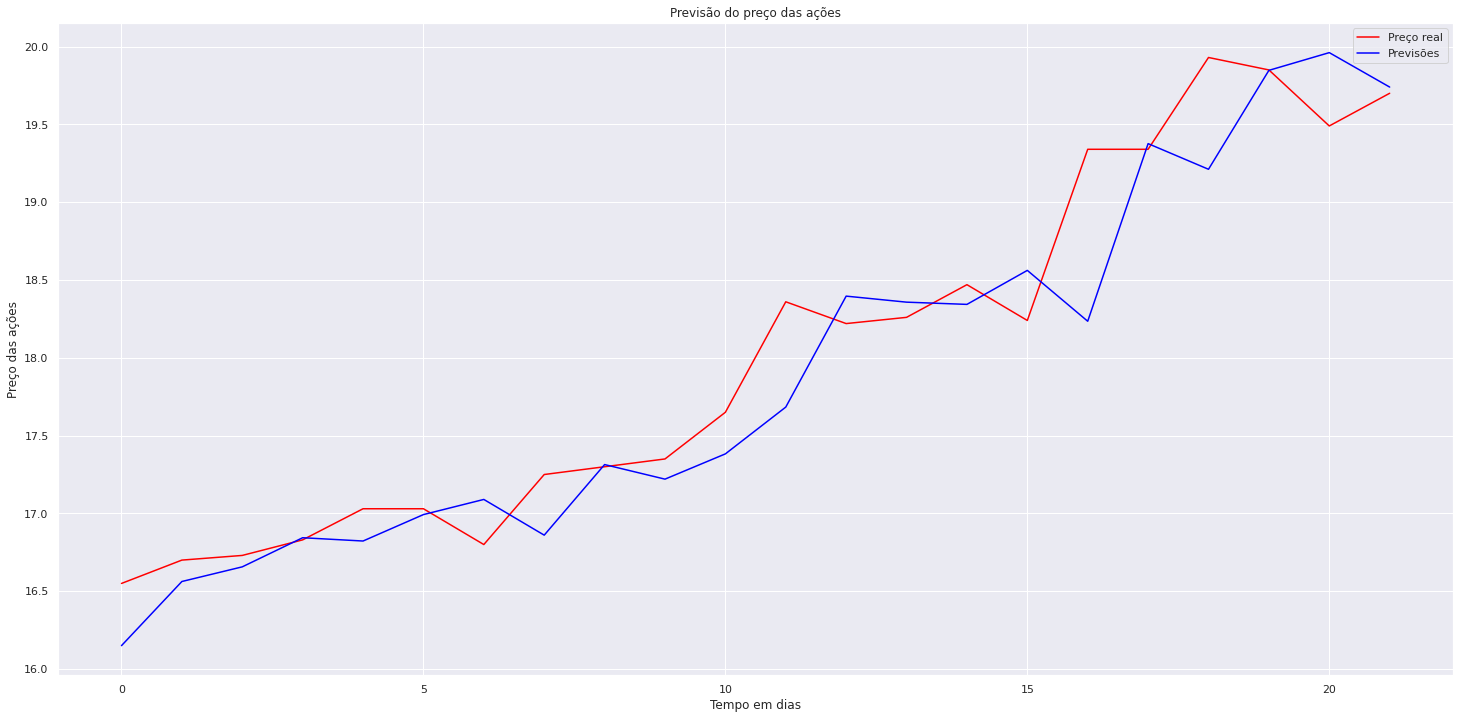

In [ ]:
base_teste = pd.read_csv('/content/PETR4_teste.csv')
base_teste = base_teste.drop('Date', axis = 1)
preco_real_teste = base_teste.iloc[:, 3:4].values
frames = [base, base_teste]
base_completa = pd.concat(frames)

entradas = base_completa[len(base_completa) - len(base_teste) - 100:].values
entradas = normalizador.transform(entradas)

Percorrer_teste = []
for i in range(100, 122): 
    Percorrer_teste.append(entradas[i-100:i, 0:6])
Percorrer_teste = np.array(Percorrer_teste)

previsoes = regressor.predict(Percorrer_teste)
previsoes = normalizador_previsao.inverse_transform(previsoes)

#previsoes.mean()
#preco_real_teste.mean()
plt.plot(preco_real_teste, color = 'red', label = 'Preço real')
plt.plot(previsoes, color = 'blue', label = 'Previsões')
plt.title('Previsão do preço das ações')
plt.xlabel('Tempo em dias')
plt.ylabel('Preço das ações')
plt.legend()
plt.show()
